In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA





In [2]:
class AnnoyIndex():
    def __init__(self, vectors, labels, metric):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
        self.metric= metric
   
    def build(self, number_of_trees=100):
        self.index = annoy.AnnoyIndex(self.dimension, self.metric)
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=1000):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=-1)                                           
        return [self.labels[i] for i in indices]
    
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                         'feature_anderson_darling_normal_magn_r',
                         'feature_beyond_1_std_magn_r', 
                         'feature_beyond_2_std_magn_r',
                         'feature_cusum_magn_r', 
                         #'feature_eta_e_magn_r',
                         'feature_inter_percentile_range_2_magn_r',
                         'feature_inter_percentile_range_10_magn_r',
                         'feature_inter_percentile_range_25_magn_r', 
                         'feature_kurtosis_magn_r',
                         'feature_linear_fit_slope_magn_r',
                         'feature_linear_fit_slope_sigma_magn_r',
                         #'feature_linear_fit_reduced_chi2_magn_r', 
                         'feature_linear_trend_magn_r',
                         'feature_linear_trend_sigma_magn_r',
                         'feature_magnitude_percentage_ratio_40_5_magn_r',
                         'feature_magnitude_percentage_ratio_20_5_magn_r',
                         #'feature_maximum_slope_magn_r',
                         'feature_mean_magn_r',
                         'feature_median_absolute_deviation_magn_r',
                         'feature_percent_amplitude_magn_r',
                         'feature_median_buffer_range_percentage_10_magn_r',
                         'feature_median_buffer_range_percentage_20_magn_r',
                         'feature_percent_difference_magnitude_percentile_5_magn_r',
                         'feature_percent_difference_magnitude_percentile_10_magn_r',
                         #'feature_period_0_magn_r',  # should be negated
                         'feature_period_s_to_n_0_magn_r',
                         #'feature_period_1_magn_r', 
                         'feature_period_s_to_n_1_magn_r',
                         #'feature_period_2_magn_r', 
                         'feature_period_s_to_n_2_magn_r',
                         #'feature_period_3_magn_r', 
                         'feature_period_s_to_n_3_magn_r',
                         #'feature_period_4_magn_r', 
                         'feature_period_s_to_n_4_magn_r',
                         #'feature_periodogram_amplitude_magn_r',
                         'feature_periodogram_beyond_2_std_magn_r',
                         'feature_periodogram_beyond_3_std_magn_r',
                         'feature_periodogram_standard_deviation_magn_r', 
                         #'feature_chi2_magn_r',
                         'feature_skew_magn_r', 
                         'feature_standard_deviation_magn_r',
                         'feature_stetson_k_magn_r',
                         'feature_weighted_mean_magn_r',
                         'feature_anderson_darling_normal_flux_r', 
                         'feature_cusum_flux_r',
                         #'feature_eta_e_flux_r', 
                         'feature_excess_variance_flux_r',
                         'feature_kurtosis_flux_r', 
                         'feature_mean_variance_flux_r',
                         #'feature_chi2_flux_r', 
                         'feature_skew_flux_r',
                         'feature_stetson_k_flux_r',

                         'feature_amplitude_magn_g', 
                         'feature_anderson_darling_normal_magn_g',
                         'feature_beyond_1_std_magn_g', 
                         'feature_beyond_2_std_magn_g',
                         'feature_cusum_magn_g', 
                         #'feature_eta_e_magn_g',
                         'feature_inter_percentile_range_2_magn_g',
                         'feature_inter_percentile_range_10_magn_g',
                         'feature_inter_percentile_range_25_magn_g', 
                         'feature_kurtosis_magn_g',
                         'feature_linear_fit_slope_magn_g',
                         'feature_linear_fit_slope_sigma_magn_g',
                         #'feature_linear_fit_reduced_chi2_magn_g', 
                         'feature_linear_trend_magn_g',
                         'feature_linear_trend_sigma_magn_g',
                         'feature_magnitude_percentage_ratio_40_5_magn_g',
                         'feature_magnitude_percentage_ratio_20_5_magn_g',
                         #'feature_maximum_slope_magn_g', 
                         'feature_mean_magn_g',
                         'feature_median_absolute_deviation_magn_g',
                         'feature_median_buffer_range_percentage_10_magn_g',
                         'feature_median_buffer_range_percentage_20_magn_g',
                         'feature_percent_amplitude_magn_g',
                         'feature_percent_difference_magnitude_percentile_5_magn_g',
                         'feature_percent_difference_magnitude_percentile_10_magn_g',
                         #'feature_period_0_magn_g',  # should be negated
                         'feature_period_s_to_n_0_magn_g',
                         #'feature_period_1_magn_g', 
                         'feature_period_s_to_n_1_magn_g',
                         #'feature_period_2_magn_g', 
                         'feature_period_s_to_n_2_magn_g',
                         #'feature_period_3_magn_g', 
                         'feature_period_s_to_n_3_magn_g',
                         #'feature_period_4_magn_g', 
                         'feature_period_s_to_n_4_magn_g',
                         #'feature_periodogram_amplitude_magn_g',
                         'feature_periodogram_beyond_2_std_magn_g',
                         'feature_periodogram_beyond_3_std_magn_g',
                         'feature_periodogram_standard_deviation_magn_g', 
                         #'feature_chi2_magn_g',
                         'feature_skew_magn_g', 
                         'feature_standard_deviation_magn_g',
                         'feature_stetson_k_magn_g', 
                         'feature_weighted_mean_magn_g',
                         'feature_anderson_darling_normal_flux_g', 
                         'feature_cusum_flux_g',
                         #'feature_eta_e_flux_g', 
                         'feature_excess_variance_flux_g',
                         'feature_kurtosis_flux_g', 
                         'feature_mean_variance_flux_g',
                         #'feature_chi2_flux_g', 
                         'feature_skew_flux_g',
                         'feature_stetson_k_flux_g'] 
    
ztf_id_and_features_r_g = ['Unnamed: 0'] + ['locus_id', 'ra', 'dec',\
                            'tags', 'catalogs', 'ztf_object_id', 'ztf_ssnamenr', 'num_alerts',\
                            'num_mag_values', 'oldest_alert_id', 'oldest_alert_magnitude',\
                            'oldest_alert_observation_time', 'newest_alert_id',\
                            'newest_alert_magnitude', 'newest_alert_observation_time',\
                            'brightest_alert_id', 'brightest_alert_magnitude', \
                            'brightest_alert_observation_time'] + feature_names_r_g +\
                        ['horizons_targetname', 'anomaly', 'anom_score', 'anomaly_score',\
                         'anomaly_mask', 'anomaly_type', 'is_corrected', 'vpdf_extreme_version',\
                         'vpdf_extreme_faint', 'vpdf_extreme_bright', 'locus_gal_l', 'locus_gal_b']


feature_names_hostgal = [
#  'Unnamed: 0',
#  'level_0',
#  'index',
#  'objName',
#  'objAltName1',
#  'objAltName2',
#  'objAltName3',
#  'objID',
#  'uniquePspsOBid',
#  'ippObjID',
#  'surveyID',
#  'htmID',
#  'zoneID',
#  'tessID',
#  'projectionID',
#  'skyCellID',
#  'randomID',
#  'batchID',
#  'dvoRegionID',
#  'processingVersion',
#  'objInfoFlag',
#  'qualityFlag',
#  'raStack',
#  'decStack',
#  'raStackErr',
#  'decStackErr',
#  'raMean',
#  'decMean',
#  'raMeanErr',
#  'decMeanErr',
#  'epochMean',
#  'posMeanChisq',
#  'cx',
#  'cy',
#  'cz',
#  'lambda',
#  'beta',
#  'l',
#  'b',
#  'nStackObjectRows',
#  'nStackDetections',
#  'nDetections',
#  'ng',
#  'nr',
#  'ni',
#  'nz',
#  'ny',
#  'uniquePspsSTid',
#  'primaryDetection',
#  'bestDetection',
#  'gippDetectID',
#  'gstackDetectID',
#  'gstackImageID',
#  'gra',
#  'gdec',
#  'graErr',
#  'gdecErr',
#  'gEpoch',
#  'gPSFMag',
#  'gPSFMagErr',
#  'gApMag',
#  'gApMagErr',
#  'gKronMag',
#  'gKronMagErr',
#  'ginfoFlag',
#  'ginfoFlag2',
#  'ginfoFlag3',
#  'gnFrames',
#  'gxPos',
#  'gyPos',
#  'gxPosErr',
#  'gyPosErr',
#  'gpsfMajorFWHM',
#  'gpsfMinorFWHM',
#  'gpsfTheta',
#  'gpsfCore',
#  'gpsfLikelihood',
#  'gpsfQf',
#  'gpsfQfPerfect',
#  'gpsfChiSq',
 'gmomentXX',
 'gmomentXY',
 'gmomentYY',
 'gmomentR1',
 'gmomentRH',
 'gPSFFlux',
#  'gPSFFluxErr',
 'gApFlux',
#  'gApFluxErr',
#  'gApFillFac',
#  'gApRadius',
 'gKronFlux',
#  'gKronFluxErr',
 'gKronRad',
#  'gexpTime',
 'gExtNSigma',
#  'gsky',
#  'gskyErr',
#  'gzp',
#  'gPlateScale',
#  'rippDetectID',
#  'rstackDetectID',
#  'rstackImageID',
#  'rra',
#  'rdec',
#  'rraErr',
#  'rdecErr',
#  'rEpoch',
# 'rPSFMag',
#  'rPSFMagErr',
# 'rApMag',
#  'rApMagErr',
# 'rKronMag',
#  'rKronMagErr',
#  'rinfoFlag',
#  'rinfoFlag2',
#  'rinfoFlag3',
#  'rnFrames',
#  'rxPos',
#  'ryPos',
#  'rxPosErr',
#  'ryPosErr',
#  'rpsfMajorFWHM',
#  'rpsfMinorFWHM',
#  'rpsfTheta',
#  'rpsfCore',
#  'rpsfLikelihood',
#  'rpsfQf',
#  'rpsfQfPerfect',
#  'rpsfChiSq',
 'rmomentXX',
 'rmomentXY',
 'rmomentYY',
 'rmomentR1',
 'rmomentRH',
'rPSFFlux',
#  'rPSFFluxErr',
'rApFlux',
#  'rApFluxErr',
#  'rApFillFac',
# 'rApRadius',
'rKronFlux',
#  'rKronFluxErr',
'rKronRad',
#  'rexpTime',
 'rExtNSigma',
#  'rsky',
#  'rskyErr',
#  'rzp',
#  'rPlateScale',
#  'iippDetectID',
#  'istackDetectID',
#  'istackImageID',
#  'ira',
#  'idec',
#  'iraErr',
#  'idecErr',
#  'iEpoch',
#  'iPSFMag',
#  'iPSFMagErr',
#  'iApMag',
#  'iApMagErr',
#  'iKronMag',
#  'iKronMagErr',
#  'iinfoFlag',
#  'iinfoFlag2',
#  'iinfoFlag3',
#  'inFrames',
#  'ixPos',
#  'iyPos',
#  'ixPosErr',
#  'iyPosErr',
#  'ipsfMajorFWHM',
#  'ipsfMinorFWHM',
#  'ipsfTheta',
#  'ipsfCore',
#  'ipsfLikelihood',
#  'ipsfQf',
#  'ipsfQfPerfect',
#  'ipsfChiSq',
  'imomentXX',
 'imomentXY',
 'imomentYY',
 'imomentR1',
 'imomentRH',
 'iPSFFlux',
#  'iPSFFluxErr',
 'iApFlux',
#  'iApFluxErr',
#  'iApFillFac',
#  'iApRadius',
 'iKronFlux',
#  'iKronFluxErr',
 'iKronRad',
#  'iexpTime',
  'iExtNSigma',
#  'isky',
#  'iskyErr',
#  'izp',
#  'iPlateScale',
#  'zippDetectID',
#  'zstackDetectID',
#  'zstackImageID',
#  'zra',
#  'zdec',
#  'zraErr',
#  'zdecErr',
#  'zEpoch',
#  'zPSFMag',
#  'zPSFMagErr',
#  'zApMag',
#  'zApMagErr',
#  'zKronMag',
#  'zKronMagErr',
#  'zinfoFlag',
#  'zinfoFlag2',
#  'zinfoFlag3',
#  'znFrames',
#  'zxPos',
#  'zyPos',
#  'zxPosErr',
#  'zyPosErr',
#  'zpsfMajorFWHM',
#  'zpsfMinorFWHM',
#  'zpsfTheta',
#  'zpsfCore',
#  'zpsfLikelihood',
#  'zpsfQf',
#  'zpsfQfPerfect',
#  'zpsfChiSq',
#   'zmomentXX',
#  'zmomentXY',
#  'zmomentYY',
#  'zmomentR1',
#  'zmomentRH',
#  'zPSFFlux',
# #  'zPSFFluxErr',
#  'zApFlux',
# #  'zApFluxErr',
# #  'zApFillFac',
# #  'zApRadius',
#  'zKronFlux',
# #  'zKronFluxErr',
#  'zKronRad',
# #  'zexpTime',
#   'zExtNSigma',
#  'zsky',
#  'zskyErr',
#  'zzp',
#  'zPlateScale',
#  'yippDetectID',
#  'ystackDetectID',
#  'ystackImageID',
#  'yra',
#  'ydec',
#  'yraErr',
#  'ydecErr',
#  'yEpoch',
#  'yPSFMag',
#  'yPSFMagErr',
#  'yApMag',
#  'yApMagErr',
#  'yKronMag',
#  'yKronMagErr',
#  'yinfoFlag',
#  'yinfoFlag2',
#  'yinfoFlag3',
#  'ynFrames',
#  'yxPos',
#  'yyPos',
#  'yxPosErr',
#  'yyPosErr',
#  'ypsfMajorFWHM',
#  'ypsfMinorFWHM',
#  'ypsfTheta',
#  'ypsfCore',
#  'ypsfLikelihood',
#  'ypsfQf',
#  'ypsfQfPerfect',
#  'ypsfChiSq',
#   'ymomentXX',
#   'ymomentXY',
#   'ymomentYY',
#   'ymomentR1',
#   'ymomentRH',
#   'yPSFFlux',
# #   'yPSFFluxErr',
#   'yApFlux',
# #   'yApFluxErr',
# #   'yApFillFac',
# #  'yApRadius',
#  'yKronFlux',
# #  'yKronFluxErr',
#  'yKronRad',
# #  'yexpTime',
#   'yExtNSigma',
#  'ysky',
#  'yskyErr',
#  'yzp',
#  'yPlateScale',
#  'distance',
#  'SkyMapper_StarClass',
#  'gelong',
#  'g_a',
#  'g_b',
#  'g_pa',
#  'relong',
#  'r_a',
#  'r_b',
#  'r_pa',
#  'ielong',
#  'i_a',
#  'i_b',
#  'i_pa',
#  'zelong',
#  'z_a',
#  'z_b',
#  'z_pa',
#    'i-z', # try throwing in
#    'g-r',
#    'r-i',
#    'g-i',
#    'z-y',
#   'g-rErr',
#   'r-iErr',
#   'i-zErr',
#   'z-yErr',
 'gApMag_gKronMag',
 'rApMag_rKronMag',
 'iApMag_iKronMag',
#  'zApMag_zKronMag',
#  'yApMag_yKronMag',
 '7DCD', 
#  'NED_name',
#  'NED_type',
#  'NED_vel',
#  'NED_redshift',
#  'NED_mag',
#  'class',
   'dist/DLR',
#   'dist',
#  'TransientClass',
#  'TransientRA',
#  'TransientDEC'
   ]

lc_and_host_features = feature_names_r_g+feature_names_hostgal

In [3]:
dataset_bank_90k = pd.read_csv('../loci_dbs/loci_df_271688objects_cut_stars_and_gal_plane_transf.csv', 
                                   compression='gzip',
                                   usecols=lambda c: c in ztf_id_and_features_r_g,)
                                  #)
        
# drop row if any feature values are nan
dataset_bank_90k = dataset_bank_90k[~dataset_bank_90k[feature_names_r_g].isnull().any(axis=1)]

#mask = (dataset_bank['num_mag_values'] >= 40) #& (dataset_bank['num_mag_values'] <= 40)
#dataset_bank = dataset_bank[mask]
dataset_bank_90k.drop_duplicates(subset="ztf_object_id", keep='first', inplace=True)
dataset_bank_90k = dataset_bank_90k.set_index('ztf_object_id')
dataset_bank_90k.index.rename("TransientName", inplace=True)
dataset_bank_90k

/Users/patrickaleo/miniconda3/envs/laiss/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (7,125,129,130,131,132,133,134) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,anom_score,anomaly_score,anomaly_mask,anomaly_type,is_corrected,vpdf_extreme_version,vpdf_extreme_faint,vpdf_extreme_bright,locus_gal_l,locus_gal_b
TransientName,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,197.881532,-69.513571
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.200342,-26.246909
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.189482,-24.352953
ZTF18aczbnhl,97,ANT2019dsk24,85.049145,-11.013302,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,105,12,ztf_candidate:718232301815010005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.961559,-20.751422
ZTF18actbhqt,98,ANT202066j3s,75.082443,-11.302676,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,89,14,ztf_candidate:702289832715010026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,210.690974,-29.741520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18adairvu,999924,ANT2020ro626,84.348727,-2.927551,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,96,10,ztf_candidate:722282332515010003,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.956641,-17.786773
ZTF20aaiwhct,999926,ANT2020pxghw,64.146691,-1.656598,"['dimmers', 'lc_feature_extractor']","['gaia_dr2', 'bright_guide_star_cat', 'allwise']",NaN,86,35,ztf_candidate:1113204944015010026,...,NaN,NaN,NaN,TBD,NaN,NaN,NaN,NaN,194.540371,-34.719753
ZTF20aberawv,999927,ANT2020aebbk,292.910293,54.078978,"['lc_feature_extractor', 'dimmers']",[],NaN,235,96,ztf_candidate:1231482062015010023,...,NaN,0.417276,Fail,TBD,NaN,NaN,NaN,NaN,85.961850,16.149525


In [4]:
# Instead of above, read in from csv files with host gal info!
# Visually vetted GHOST results split up over XXX files
# So merge them

dfs = []
for start_idx, end_idx in zip(range(0, 38600, 100), range(100, 38700, 100)): #90199, 90299
    df = pd.read_csv(f'./host_info/dataset_bank_hosts_start_idx:end_idx={start_idx}:{end_idx}.csv')
    dfs.append(df)
    
g_hosts_df = pd.concat(dfs, axis=0).reset_index(drop=True)
g_hosts_df.drop_duplicates(subset="TransientName", keep='first', inplace=True)
g_hosts_df = g_hosts_df.set_index('TransientName')
g_hosts_df.sort_values('TransientName', inplace=True)
#g_hosts_df.reset_index(inplace=True, drop=True)
g_hosts_df

,objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
TransientName,,,,,,,,,,,,,,,,,,,,,
AT2019ye,PSO J135804.487+203809.056,NaN,NaN,NaN,132762095186853570,916270000024592,143378893266959,0,14931762990582,13276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2018ajl,PSO J190429.931+465408.150,NaN,NaN,NaN,164282861247243384,980181000018761,286229505526092,0,14030330328091,16428,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2018avp,PSO J130026.839+183711.266,NaN,NaN,NaN,130341951118084283,908497000031128,142408230664599,0,15113135908185,13034,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2018big,PSO J172538.410+592648.115,NaN,NaN,NaN,179332614100166803,964525000048937,310173948231464,0,14734825883801,17933,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SN2018bsq,PSO J163542.973+044933.438,NaN,NaN,NaN,113792489291811431,939825000003319,68908455300342,0,14520321933257,11379,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21acowflo,PSO J115325.672-020751.472,NaN,NaN,NaN,105441783569413306,1060899000037885,380577052136444,0,10449544781519,10544,...,1.0,15.4833,5.93330,7.21031,1.71088,1.59629,NaN,0.0,False,NaN
ZTF21acqdfea,PSO J224851.522-233559.187,NaN,NaN,NaN,79683422147160553,1052742000058092,520253683589867,0,12857462044241,7968,...,1.0,12.1327,4.68567,4.06547,6.92097,4.41143,NaN,0.0,False,NaN
ZTF21acqetxn,PSO J235011.541+191045.231,NaN,NaN,NaN,131013575480825509,1076778000026511,161254547154832,0,13215295323352,13101,...,1.0,11.9638,5.68306,3.76124,3.02015,NaN,NaN,0.0,NaN,NaN


In [5]:
len(np.unique(g_hosts_df.index))

10927

In [6]:
# merge ghost info and databank info

# rename as dataset_bank
dataset_bank = pd.merge(dataset_bank_90k, g_hosts_df, left_index=True, right_index=True, how='inner')
dataset_bank.index.rename("ztf_object_id", inplace=True)
dataset_bank

,Unnamed: 0,locus_id,ra,dec,tags,catalogs,ztf_ssnamenr,num_alerts,num_mag_values,oldest_alert_id,...,primaryDetection_y,gpetR90,rpetR90,ipetR90,zpetR90,ypetR90,NED_redshift_flag,hasSimbad,class,level_0
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,6,ANT2020rajqu,33.976088,-20.258905,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,137,35,ztf_candidate:993481181415010007,...,1.0,6.10360,4.04109,1.675730,3.49369,29.58050,NaN,0.0,False,NaN
ZTF18acfvwwa,39,ANT2020pc6ko,35.639509,32.833982,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,659,88,ztf_candidate:943483942915015010,...,1.0,7.05256,1.08888,1.214940,3.95098,1.72927,NaN,0.0,False,NaN
ZTF17aaaskvj,58,ANT2020rdpmm,28.015003,36.953217,['lc_feature_extractor'],"['allwise', 'csdr2', 'gaia_dr2', '2mass_psc', ...",NaN,1497,579,ztf_candidate:598425334815010002,...,1.0,3.99288,1.86034,0.730485,1.92726,1.96452,NaN,0.0,NaN,NaN
ZTF18actbhqt,98,ANT202066j3s,75.082443,-11.302676,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,89,14,ztf_candidate:702289832715010026,...,1.0,NaN,NaN,2.092530,NaN,NaN,NaN,1.0,NaN,NaN
ZTF20aciscxz,100,ANT2020aegc7vi,83.973369,-9.123083,"['lc_feature_extractor', 'high_flux_ratio_wrt_...","['allwise', 'bright_guide_star_cat']",NaN,48,18,ztf_candidate:1356481843915015002,...,1.0,1.05484,1.57786,1.876240,0.98579,1.65329,NaN,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxtpty,449757,ANT2021l2lcg,223.794755,-6.985929,"['lc_feature_extractor', 'nuclear_transient', ...","['allwise', 'bright_guide_star_cat', 'PS1StarG...",NaN,47,25,ztf_candidate:1580234905915015000,...,1.0,3.43007,2.90656,2.904020,4.13958,11.54750,NaN,0.0,False,NaN
ZTF18abfdzhd,449766,ANT2018dkplc,283.516119,79.735891,['lc_feature_extractor'],"['allwise', 'gaia_dr2', '2mass_psc', 'bright_g...",NaN,389,14,ztf_candidate:552405336115010193,...,1.0,8.21196,2.41345,2.527050,2.12905,1.65573,NaN,0.0,False,NaN
ZTF18ablgnri,449772,ANT2019arvqc,326.288226,4.030059,['lc_feature_extractor'],"['bright_guide_star_cat', 'allwise', '2mass_ps...",NaN,41,15,ztf_candidate:1081076871615010026,...,1.0,10.91240,2.50994,2.601400,2.47185,5.08331,NaN,0.0,False,NaN


In [7]:
dataset_bank.columns.to_list()

['Unnamed: 0',
 'locus_id',
 'ra',
 'dec',
 'tags',
 'catalogs',
 'ztf_ssnamenr',
 'num_alerts',
 'num_mag_values',
 'oldest_alert_id',
 'oldest_alert_magnitude',
 'oldest_alert_observation_time',
 'newest_alert_id',
 'newest_alert_magnitude',
 'newest_alert_observation_time',
 'brightest_alert_id',
 'brightest_alert_magnitude',
 'brightest_alert_observation_time',
 'feature_amplitude_magn_g',
 'feature_anderson_darling_normal_magn_g',
 'feature_beyond_1_std_magn_g',
 'feature_beyond_2_std_magn_g',
 'feature_cusum_magn_g',
 'feature_inter_percentile_range_2_magn_g',
 'feature_inter_percentile_range_10_magn_g',
 'feature_inter_percentile_range_25_magn_g',
 'feature_kurtosis_magn_g',
 'feature_linear_fit_slope_magn_g',
 'feature_linear_fit_slope_sigma_magn_g',
 'feature_linear_trend_magn_g',
 'feature_linear_trend_sigma_magn_g',
 'feature_magnitude_percentage_ratio_40_5_magn_g',
 'feature_magnitude_percentage_ratio_20_5_magn_g',
 'feature_mean_magn_g',
 'feature_median_absolute_deviation

In [8]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features]
dataset_bank_orig.isnull().sum().to_dict() # see which columns have most NaNs

{'feature_amplitude_magn_r': 0,
 'feature_anderson_darling_normal_magn_r': 0,
 'feature_beyond_1_std_magn_r': 0,
 'feature_beyond_2_std_magn_r': 0,
 'feature_cusum_magn_r': 0,
 'feature_inter_percentile_range_2_magn_r': 0,
 'feature_inter_percentile_range_10_magn_r': 0,
 'feature_inter_percentile_range_25_magn_r': 0,
 'feature_kurtosis_magn_r': 0,
 'feature_linear_fit_slope_magn_r': 0,
 'feature_linear_fit_slope_sigma_magn_r': 0,
 'feature_linear_trend_magn_r': 0,
 'feature_linear_trend_sigma_magn_r': 0,
 'feature_magnitude_percentage_ratio_40_5_magn_r': 0,
 'feature_magnitude_percentage_ratio_20_5_magn_r': 0,
 'feature_mean_magn_r': 0,
 'feature_median_absolute_deviation_magn_r': 0,
 'feature_percent_amplitude_magn_r': 0,
 'feature_median_buffer_range_percentage_10_magn_r': 0,
 'feature_median_buffer_range_percentage_20_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_5_magn_r': 0,
 'feature_percent_difference_magnitude_percentile_10_magn_r': 0,
 'feature_period_s_to_n_0_

In [9]:
# only keep features of bank
dataset_bank_orig = dataset_bank[lc_and_host_features] #dataset_bank[feature_names_r_g]
# drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]

dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,2.176230,-0.001783,...,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571
ZTF18acfvwwa,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,0.552720,0.000145,...,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505
ZTF20aciscxz,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,-0.871550,0.001117,...,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062
ZTF18abdkosj,1.776150,-0.175299,0.200000,0.000000,0.353906,3.552299,3.552299,1.268549,2.222622,0.005808,...,0.000200,0.000506,0.001007,7.09951,33.325699,0.687300,0.689600,0.746500,15.107083,4.124426
ZTF18abrcoty,0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,0.004197,...,0.000156,0.000398,0.001222,10.69920,15.298800,1.296299,1.073200,1.217402,20.028593,0.130795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxtpty,0.368228,-0.224743,0.363636,0.000000,0.428368,0.736456,0.620806,0.468203,-1.134349,0.004781,...,0.000039,0.000098,0.000119,4.41839,27.199499,0.136398,0.145201,0.218699,8.139425,0.021236
ZTF18abfdzhd,1.003501,-0.660953,0.333333,0.000000,0.384789,2.007002,1.911265,1.049637,0.125196,0.001744,...,0.000050,0.000065,0.000063,3.22952,5.129270,-0.011501,-0.044199,-0.027300,6.596264,3.799808
ZTF18ablgnri,0.947349,-0.185665,0.181818,0.000000,0.422509,1.894697,1.429150,0.971006,-0.365199,-0.003411,...,0.000026,0.000049,0.000058,3.93640,23.481300,0.272800,0.383799,0.190201,35.253217,4.417624


In [10]:
dataset_bank_host_ra_dec = dataset_bank[['raMean', 'decMean']]

dataset_bank_orig_host_ra_dec = pd.concat([dataset_bank_host_ra_dec, dataset_bank_orig], axis=1)
dataset_bank_orig_host_ra_dec

,raMean,decMean,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acpdyyq,33.970428,-20.262357,0.514069,-0.037026,0.230769,0.277350,0.210596,1.028137,0.606000,0.224944,...,0.000010,0.000018,0.000016,2.72844,5.283530,-0.122499,-0.208099,-0.147800,66.227214,3.921571
ZTF18acfvwwa,35.632326,32.837878,0.593122,-0.303523,0.303030,0.246183,0.272132,1.152622,0.729088,0.356500,...,0.000024,0.000024,0.000022,2.07345,0.672845,-0.022400,-0.078699,-0.078100,10.879219,4.737505
ZTF17aaaskvj,28.019186,36.949659,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18actbhqt,75.082493,-11.302689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF20aciscxz,83.973390,-9.123059,0.285049,-0.425467,0.384615,0.000000,0.375905,0.570099,0.455701,0.273037,...,0.000016,0.000016,0.000015,2.09795,-0.243484,-0.117100,-0.058001,-0.122601,31.205722,0.113062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aaxtpty,223.794775,-6.985928,0.368228,-0.224743,0.363636,0.000000,0.428368,0.736456,0.620806,0.468203,...,0.000039,0.000098,0.000119,4.41839,27.199499,0.136398,0.145201,0.218699,8.139425,0.021236
ZTF18abfdzhd,283.519371,79.728243,1.003501,-0.660953,0.333333,0.000000,0.384789,2.007002,1.911265,1.049637,...,0.000050,0.000065,0.000063,3.22952,5.129270,-0.011501,-0.044199,-0.027300,6.596264,3.799808
ZTF18ablgnri,326.277602,4.023072,0.947349,-0.185665,0.181818,0.000000,0.422509,1.894697,1.429150,0.971006,...,0.000026,0.000049,0.000058,3.93640,23.481300,0.272800,0.383799,0.190201,35.253217,4.417624


In [11]:
dataset_bank_catalogs = dataset_bank[['catalogs']]

dataset_bank_orig_catalogs = pd.concat([dataset_bank_catalogs, dataset_bank_orig], axis=1)

# bright_guide_star_cat unfortunately has some non stars that are good galaxies with SN in them...
dataset_bank_orig_catalogs_no_bright_star = dataset_bank_orig_catalogs[~dataset_bank_orig_catalogs['catalogs'].str.contains('bright_guide_star_cat')]
dataset_bank_orig_catalogs_no_bright_star

,catalogs,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abrcoty,['2mass_xsc'],0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,...,0.000156,0.000398,0.001222,10.69920,15.29880,1.296299,1.073200,1.217402,20.028593,0.130795
ZTF18aatckag,"['allwise', 'gaia_dr2']",0.260850,-0.733969,0.285714,0.000000,0.339135,0.521700,0.483200,0.280875,-0.867793,...,0.000010,0.000017,0.000016,2.79870,10.56360,0.054701,-0.040501,-0.081800,32.328098,18.879176
ZTF18aahqtqd,"['gaia_dr2', 'allwise']",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18acdzyog,"['allwise', 'gaia_dr2']",0.429050,-0.728171,0.333333,0.000000,0.383885,0.858101,0.806322,0.340309,0.147949,...,0.000013,0.000017,0.000016,2.36583,3.21868,-0.242901,-0.296499,-0.082100,15.586660,4.995976
ZTF21aasfdps,[],0.077326,-1.108203,0.500000,0.000000,0.368934,0.154652,0.154652,0.096876,0.091439,...,0.000323,0.000871,0.005258,20.48020,29.60280,1.972199,2.030701,1.951900,43.788908,0.946542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18acyyxwk,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZTF18aabkyry,['gaia_dr2'],0.874744,-0.922329,0.250000,0.000000,0.316606,1.749488,1.749488,1.291385,-1.426775,...,0.000048,0.000073,0.000082,3.99580,5.23389,0.190201,0.018599,0.120800,10.553322,4.916108
ZTF20aclkyjg,[],0.382929,-0.500159,0.250000,0.288675,0.391090,0.765858,0.506778,0.290942,0.675830,...,0.000038,0.000051,0.000059,3.97474,3.73871,0.040100,0.003099,0.163700,5.391341,0.860020


In [12]:
# Choose a dataframe!!

#dataset_bank_orig = dataset_bank_orig
dataset_bank_orig = dataset_bank_orig_catalogs_no_bright_star.drop(columns=['catalogs'])
#dataset_bank_orig = dataset_bank_orig_host_ra_dec.drop(columns=['raMean', 'decMean'])

# Drop row if any feature values are nan
dataset_bank_orig = dataset_bank_orig[~dataset_bank_orig[lc_and_host_features].isnull().any(axis=1)]
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,iPSFFlux,iApFlux,iKronFlux,iKronRad,iExtNSigma,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abrcoty,0.072900,-0.738972,0.250000,0.000000,0.358274,0.145800,0.145800,0.092799,1.468299,0.004197,...,0.000156,0.000398,0.001222,10.69920,15.29880,1.296299,1.073200,1.217402,20.028593,0.130795
ZTF18aatckag,0.260850,-0.733969,0.285714,0.000000,0.339135,0.521700,0.483200,0.280875,-0.867793,-0.001265,...,0.000010,0.000017,0.000016,2.79870,10.56360,0.054701,-0.040501,-0.081800,32.328098,18.879176
ZTF18acdzyog,0.429050,-0.728171,0.333333,0.000000,0.383885,0.858101,0.806322,0.340309,0.147949,-0.001915,...,0.000013,0.000017,0.000016,2.36583,3.21868,-0.242901,-0.296499,-0.082100,15.586660,4.995976
ZTF21aasfdps,0.077326,-1.108203,0.500000,0.000000,0.368934,0.154652,0.154652,0.096876,0.091439,0.012542,...,0.000323,0.000871,0.005258,20.48020,29.60280,1.972199,2.030701,1.951900,43.788908,0.946542
ZTF18acfkmbr,0.268935,-0.668112,0.363636,0.000000,0.218645,0.537870,0.489168,0.280069,-1.010040,0.000140,...,0.000086,0.000148,0.000182,5.09361,15.66730,0.032400,0.326700,0.226801,0.687302,4.003004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aarvysz,0.100250,-1.110766,0.500000,0.000000,0.378502,0.200500,0.200500,0.130392,-0.474432,-0.004128,...,0.000011,0.000013,0.000012,2.31072,2.66882,0.288799,-0.031401,-0.121700,15.512861,4.691721
ZTF18aabkyry,0.874744,-0.922329,0.250000,0.000000,0.316606,1.749488,1.749488,1.291385,-1.426775,-0.001818,...,0.000048,0.000073,0.000082,3.99580,5.23389,0.190201,0.018599,0.120800,10.553322,4.916108
ZTF20aclkyjg,0.382929,-0.500159,0.250000,0.288675,0.391090,0.765858,0.506778,0.290942,0.675830,0.001956,...,0.000038,0.000051,0.000059,3.97474,3.73871,0.040100,0.003099,0.163700,5.391341,0.860020


In [13]:

# https://github.com/uiucsn/laiss/blob/main/LAISS/notebooks/LAISS_tests.ipynb
idx_arr = np.hstack(np.array(dataset_bank_orig.index, dtype='object'))
feat_arr = np.vstack(np.array(dataset_bank_orig, dtype='object'))


#scaler = preprocessing.StandardScaler() # Create a scalar
scaler = preprocessing.MinMaxScaler() # Create a scalar # Good
#scaler = preprocessing.MaxAbsScaler() # Create a scalar # Good

# bad scalars
#scaler = preprocessing.RobustScaler(quantile_range=(33.0, 67.0)) # quantile_range=(25.0, 75.0) good for outliers
#scaler = preprocessing.Normalizer(norm='l2') #norm='max', norm='l1',
#scaler = preprocessing.SplineTransformer(n_knots=5, degree=3, knots='uniform', 
#                                          extrapolation='constant', include_bias=True, order='C')
#scaler = preprocessing.FunctionTransformer(np.cbrt, validate=True)
#scaler = preprocessing.FunctionTransformer(np.conjugate, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)
#scaler = preprocessing.FunctionTransformer(np.rint, validate=True)

#print("scaler")
#scaler.fit(feat_arr) # Fit only to training data
#feat_arr_scaled = scaler.transform(feat_arr) # What your model learns on
#print(np.shape(feat_arr_scaled))
#print(feat_arr_scaled)



# #OR try PCA, then scalar
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))
# scaler.fit(feat_arr_scaled) # Fit only to training data
# feat_arr_scaled = scaler.transform(feat_arr_scaled) # What your model learns on

#OR try scalar then PCA
print("pca")
# Initialize PCA with 15 principal components
n_components=25
pca = PCA(n_components=n_components)
feat_arr_scaled = scaler.fit_transform(feat_arr)
feat_arr_scaled = np.array(pca.fit_transform(feat_arr_scaled))

# # #OR try PCA only
# print("pca")
# # Initialize PCA with 15 principal components
# n_components=6
# pca = PCA(n_components=n_components)
# feat_arr_scaled = np.array(pca.fit_transform(feat_arr))

# Print the explained variance
print(np.cumsum(pca.explained_variance_ratio_))

# Build ANNOY index of scaled features of dataset_bank
index = AnnoyIndex(feat_arr_scaled, idx_arr, metric='euclidean')
index.build()
# dist metrics: dot is not good, eucl and manhattan are more or less same, 
# hamming is good distance but matches aren't as similar
# angular has best matches?

pca
[0.17942138 0.32361794 0.41471511 0.49052459 0.55565077 0.60549665
 0.63539861 0.65933684 0.68217517 0.70293487 0.72277179 0.74150584
 0.75948368 0.77637235 0.79192585 0.80493039 0.81719052 0.82865597
 0.83949489 0.8500752  0.86015812 0.86890422 0.87720428 0.88435991
 0.89131365]


# TODO: get Tns classes, do distance distr per class (in diff metrics)

In [14]:
# Scalar then PCA
col_names = [f'PC'+str(i) for i in range(n_components)]
dataset_bank_pca = pd.DataFrame(pca.fit_transform(feat_arr_scaled), columns=col_names)
dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
dataset_bank_pca

# # Just PCA
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca


# # Just PCA, then scalar
# col_names = [f'PC'+str(i) for i in range(n_components)]
# dataset_bank_pca = pd.DataFrame(pca.fit_transform(dataset_bank_orig), columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca = scaler.transform(dataset_bank_pca)
# dataset_bank_pca = pd.DataFrame(dataset_bank_pca, columns=col_names)
# dataset_bank_pca = dataset_bank_pca.set_index(dataset_bank_orig.index)
# dataset_bank_pca

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abrcoty,-0.289373,-0.781059,-0.273971,0.305415,0.555486,0.554513,0.180347,-0.109538,-0.639639,-0.418097,...,-0.342584,-0.013702,-0.285742,-0.016903,-0.025268,0.158063,0.157073,-0.190340,-0.229648,-0.036834
ZTF18aatckag,1.293988,0.012607,0.847447,0.750278,0.478055,0.110546,0.398645,-0.351103,-0.381868,-0.303573,...,-0.049945,0.135676,0.330374,-0.009703,-0.027354,0.100248,-0.118088,-0.466415,-0.325462,0.136532
ZTF18acdzyog,0.612309,-0.259348,0.943837,0.345653,0.302307,-0.047425,-0.229856,0.147315,-0.314530,-0.082630,...,-0.063910,0.149476,-0.101190,0.014215,-0.068855,0.186328,-0.004945,0.041866,-0.033149,-0.139549
ZTF21aasfdps,-1.129530,-0.401426,-0.342131,-0.164329,0.162113,1.178561,-0.097744,-0.388629,0.158900,-0.358343,...,-0.204449,0.152977,0.044901,-0.308936,0.100070,0.038189,-0.054219,-0.041478,-0.066298,0.032459
ZTF18acfkmbr,0.344077,-0.720142,0.115692,0.317592,0.067708,0.305317,-0.344114,0.344769,-0.140448,0.355949,...,-0.128110,-0.085309,-0.152768,0.139932,0.373776,0.050841,-0.180159,0.165235,0.226986,0.054302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21aarvysz,-0.856182,-1.341752,0.463901,-0.439070,-0.641960,-0.067516,-0.206972,-0.279806,-0.128120,-0.420292,...,0.184963,0.142366,-0.085217,-0.144971,0.346617,-0.006076,-0.239635,-0.105629,-0.202717,0.097803
ZTF18aabkyry,0.267288,0.303003,1.606591,-0.097871,0.537233,0.065330,-0.472795,0.116627,0.044931,-0.083174,...,-0.332110,-0.047925,0.028095,0.016482,-0.112004,0.084556,0.128863,0.014279,0.111399,-0.079933
ZTF20aclkyjg,0.110243,0.250213,-0.243811,0.193223,-0.437282,-0.692917,-0.206766,-0.069627,0.210018,-0.614227,...,-0.211621,0.228414,-0.054116,-0.157723,0.030425,0.009093,-0.040598,-0.021316,0.011599,-0.006974


In [15]:
# Reference
# ZTF21aassamj	dataset_bank.iloc[-5:-4] is good Ia

#with PCA
dataset_bank = dataset_bank_pca.copy()


# # No PCA
# dataset_bank = dataset_bank_orig.copy()

# for Lc + host features 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20aciwhcb'] # Ia
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpdyyq'] # star - weird that it has host info (CHECK INTO THIS)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuyayk'] # RRyl kinda star behavior 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvmlow'] # close SN (many ANNs are HII regions
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvbbvs'] # variable - check host info
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20actvmqi'] #SN Ia w/ small ANN=1 dist
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aaxksct'] # SN Ia, z=0.1 w/ small ANN=1 dist (cool example through first few ANN)
dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwnrty'] # SN Ia
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpjcoe'] # SN Ia, z=0.04
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19aadoota'] # IIn, z=0.058
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abywydb'] #II, z=0.04 no apparent host
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acwobku'] #2020acct (matches to a couple IIb)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aabxjqr'] # IIb, z=0.03
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF19ackwoak'] # star (check host) (finds other stars)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abvlumw'] # central bogus obs in bright gal core (check host) (finds more bogus)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aacoati'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18ablgnri'] # star (check host)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aagtqna'] # long lived IIP, closeby (finds more IIs)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18acrjydf'] #CV/nova in M31 (check host in GHOST)
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax 
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18aamzgzi'] # bogus core obs

# NOTE: all stars are misassociations


# for host features only
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF21aassamj'] # SN ia (lower first ANN dist), 0.3478 [eucl.], 2.1561 [manhattan], 21.8293 [dot], 0 for first 3, then 1,2... [hamming], 0.077 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abwrcmq'] # SN iax ,  , 3.5786 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abuicad'] # SLSN z=0.135, , 4.449 [manhattan]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20abqkbfx'] # Ia-CSM , , 4.0267 [manhattan], 4 is first match, then 5 [hamming]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achncvv']  # SLSN-II
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acpbdvm'] # SN II , , 2.3857 [manhattan], 0.088 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20acveyyv'] # SN IIn
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abktckv'] # Lensing (high first ANN dist), 0.7893, 4.5839 [manhattan], 21.5625 [dot], 8! for first one, then 9,10... [hamming], 0.1678 [angular]
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF20achutoz'] # junk
#dataset_ref = dataset_bank[dataset_bank.index == 'ZTF18abtkeaf'] # star #ZTF18acdqrna #ZTF19aapunrg #ZTF18abtkeaf
dataset_ref 

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acwnrty,-0.438723,1.039765,0.269679,-0.02528,-0.288742,-0.072814,0.247369,-0.070703,-0.158085,0.116741,...,-0.142327,-0.121097,-0.028356,-0.062048,-0.090931,-0.109609,0.110259,0.087566,0.017234,0.02379


In [16]:
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# Scalar then PCA
scaled_feat_arr_ref = np.array(dataset_ref)

# # PCA only
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref

ztf_id = dataset_ref.index.values[0]
lcdata = {'name': ztf_id, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

print(f"ZTF ID name (ref) {ztf_id}") 
link_ref = f'https://alerce.online/object/{ztf_id}'
print(link_ref)
print("%%%%%%")
print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

ZTF ID name (ref) ZTF20acwnrty
https://alerce.online/object/ZTF20acwnrty
%%%%%%
ANN		ZTF_id							DIST			ps1images
0	https://alerce.online/object/ZTF20acwnrty			0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=146.10010911+22.97882115&filter=color

1	https://alerce.online/object/ZTF21aalnyny			0.4873	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=217.84229758+55.76388671&filter=color

2	https://alerce.online/object/ZTF21aaflzqy			0.4919	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=193.60045545+7.04280283&filter=color

3	https://alerce.online/object/ZTF20achdwmq			0.5218	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=109.49225817+43.5716714&filter=color

4	https://alerce.online/object/ZTF20acpxvez			0.5586	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=178.07236497+43.28707732&filter=color

5	https://alerce.online/object/ZTF21abzadod			0.5824	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=15.87801409+28.43943935&filter=color

6	https://alerce.online/object/ZTF20acw

In [17]:
results_df = dataset_bank[dataset_bank.index.isin(idx_arr[result_id])]
results_df = results_df.reindex(idx_arr[result_id])
results_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF20acwnrty,-0.438723,1.039765,0.269679,-0.025280,-0.288742,-0.072814,0.247369,-0.070703,-0.158085,0.116741,...,-0.142327,-0.121097,-0.028356,-0.062048,-0.090931,-0.109609,0.110259,0.087566,0.017234,0.023790
ZTF21aalnyny,-0.502282,1.127904,0.507507,-0.147594,-0.415495,-0.054333,0.390124,-0.014753,-0.006495,0.020640,...,-0.172471,-0.167887,-0.135976,-0.024739,-0.050713,-0.136666,0.113050,0.081290,-0.165760,0.030185
ZTF21aaflzqy,-0.445237,0.934413,0.484731,-0.034304,-0.305491,-0.160015,0.290484,0.071550,-0.203389,0.020597,...,-0.113043,-0.216851,-0.193743,-0.085953,-0.116321,-0.165544,-0.037673,-0.071406,0.046470,0.103779
ZTF20achdwmq,-0.439976,0.836909,0.345972,-0.023410,-0.501674,-0.071428,0.133831,-0.067333,-0.274007,0.146527,...,-0.196676,0.074445,-0.102615,-0.018693,-0.226012,-0.239194,0.145768,-0.015351,-0.110284,0.032147
ZTF20acpxvez,-0.510028,0.857284,0.290288,-0.034005,-0.212221,-0.195868,0.046360,-0.043057,-0.070193,0.294427,...,-0.090456,-0.001167,0.046873,0.002247,0.008277,-0.195701,-0.102311,0.100856,-0.133601,0.046660
ZTF21abzadod,-0.582192,1.188753,0.313662,-0.086503,-0.424759,0.058855,0.283125,-0.095299,-0.114640,0.110509,...,-0.084931,-0.153747,-0.130085,0.015886,-0.098554,-0.181478,0.020150,0.204457,-0.224802,-0.243782
ZTF20acwxbyr,-0.615903,1.145552,0.304014,-0.094475,-0.464359,-0.188097,0.163983,-0.070181,-0.196650,0.023833,...,-0.013120,-0.112294,-0.099391,-0.008599,0.057648,0.024795,0.202049,0.133828,-0.037527,0.081092
ZTF20acgnenc,-0.685791,1.227594,0.148191,0.067534,-0.282008,0.052032,0.051884,-0.018895,0.091173,-0.011386,...,-0.108334,-0.115704,-0.024956,-0.132406,0.027854,0.051964,0.108193,0.135866,-0.021216,0.017006
ZTF20achtxbi,-0.451120,0.824546,0.239072,-0.276025,-0.507244,-0.204840,0.087728,-0.085438,-0.096288,0.071447,...,-0.146584,-0.097258,-0.214645,0.034248,-0.100352,-0.061630,-0.018513,0.140106,-0.123422,-0.075502


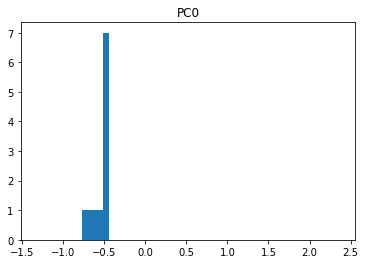

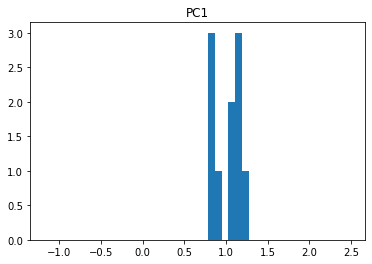

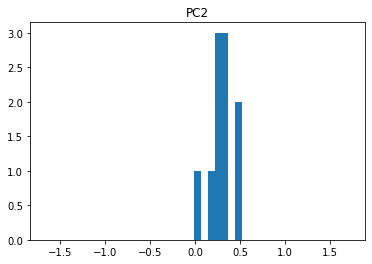

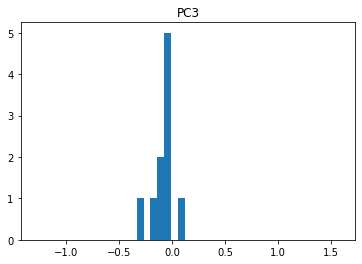

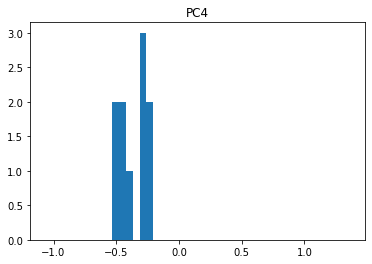

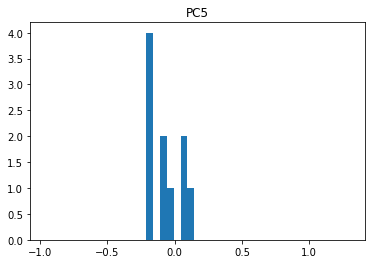

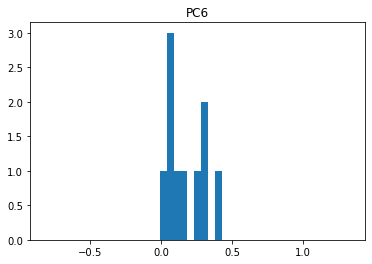

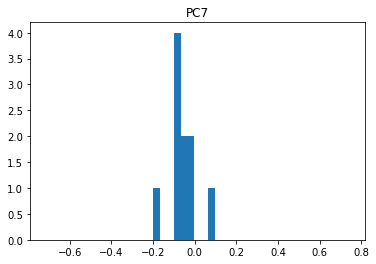

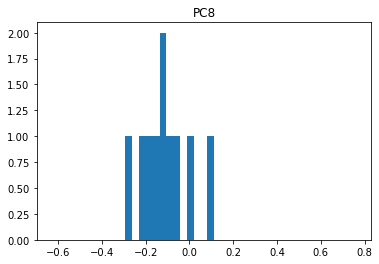

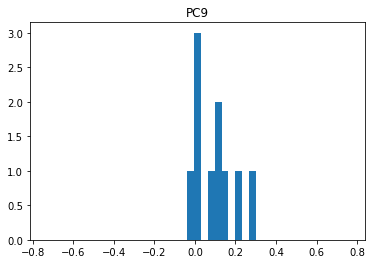

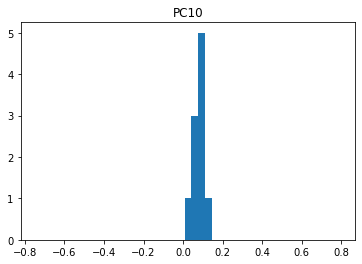

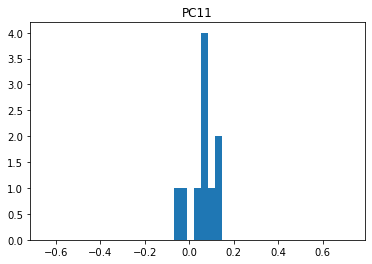

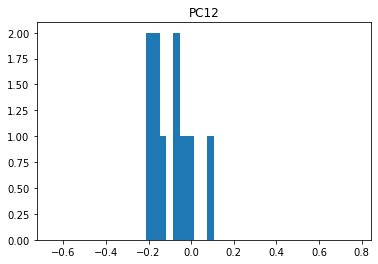

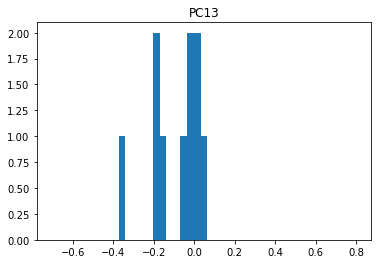

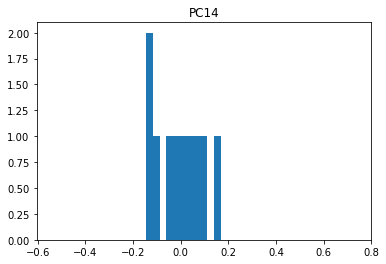

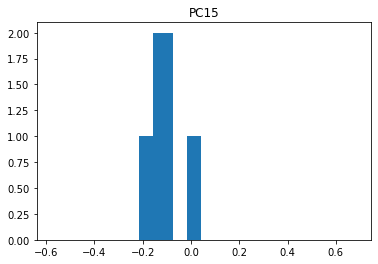

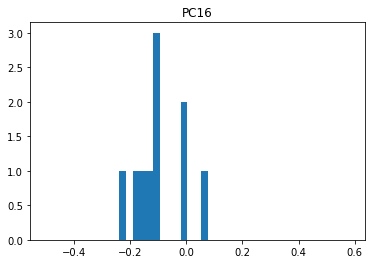

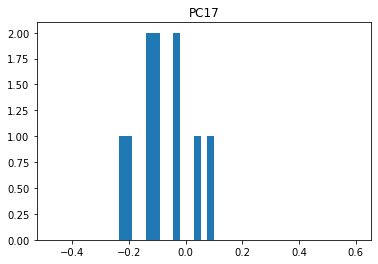

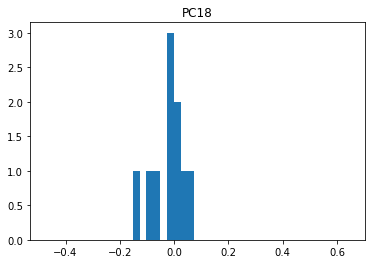

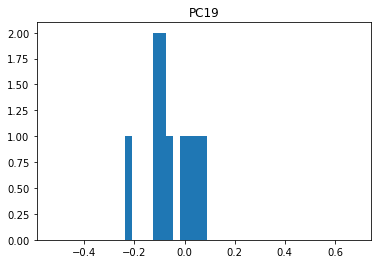

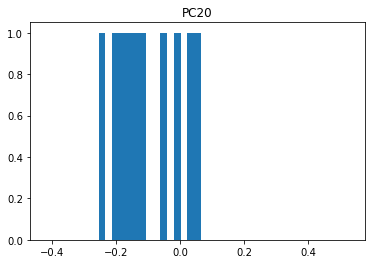

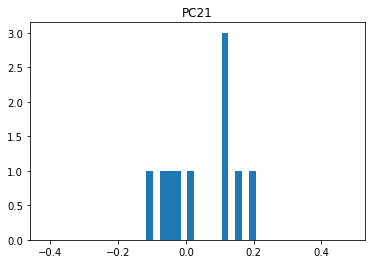

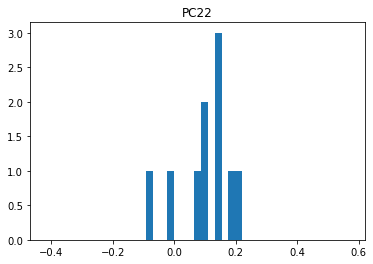

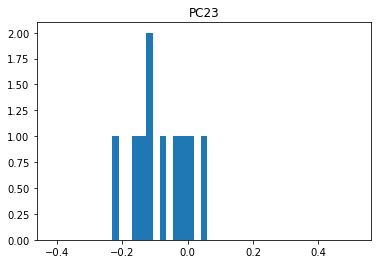

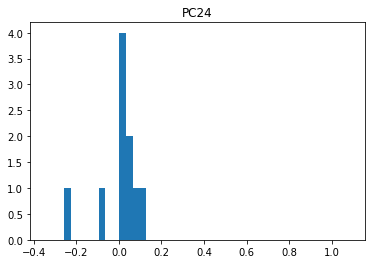

In [18]:
feat_scatter_l = []
for feat in results_df.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(results_df[feat], bins=np.linspace(min_feat, max_feat, 50))
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.show()
    
    feat_scatter = np.std(results_df[feat])
    feat_scatter_l.append(feat_scatter)    

In [19]:
print("Scatter mean:", np.mean(feat_scatter_l))
print("Scatter median:", np.median(feat_scatter_l))
print("Scatter std:", np.std(feat_scatter_l))
print("Scatter max:", np.max(feat_scatter_l))
print("Scatter min:", np.min(feat_scatter_l))

Scatter mean: 0.0903821564564552
Scatter median: 0.09268981053414427
Scatter std: 0.02410446228848148
Scatter max: 0.14326585326899172
Scatter min: 0.0291972902964596


In [20]:
list(np.unique(dataset_bank_orig.index))

['ZTF17aaaosws',
 'ZTF17aaaxbgi',
 'ZTF17aaaxcuq',
 'ZTF17aabtjot',
 'ZTF17aabuovl',
 'ZTF17aabvisz',
 'ZTF17aabvoei',
 'ZTF17aabwial',
 'ZTF17aabwnil',
 'ZTF17aabwpit',
 'ZTF17aacqbsh',
 'ZTF17aacrdcz',
 'ZTF17aacwwqs',
 'ZTF17aadhojj',
 'ZTF17aadlcod',
 'ZTF17aadmbhe',
 'ZTF17aadnacr',
 'ZTF17aadnnqu',
 'ZTF18aaadkqq',
 'ZTF18aaafciz',
 'ZTF18aaaglmc',
 'ZTF18aaahuou',
 'ZTF18aaasemf',
 'ZTF18aaavrep',
 'ZTF18aaawoza',
 'ZTF18aabdutk',
 'ZTF18aabjkom',
 'ZTF18aabjliz',
 'ZTF18aabkuoq',
 'ZTF18aabkyry',
 'ZTF18aabldzj',
 'ZTF18aabpmmq',
 'ZTF18aabxqsf',
 'ZTF18aabxquq',
 'ZTF18aabzreg',
 'ZTF18aacjkkt',
 'ZTF18aacybto',
 'ZTF18aaenhfu',
 'ZTF18aaerohw',
 'ZTF18aaflcyp',
 'ZTF18aafsrrp',
 'ZTF18aafzers',
 'ZTF18aagslba',
 'ZTF18aagvosz',
 'ZTF18aagxqqo',
 'ZTF18aagymbb',
 'ZTF18aahfaex',
 'ZTF18aahjfau',
 'ZTF18aaifids',
 'ZTF18aaikcbb',
 'ZTF18aaimlad',
 'ZTF18aaiscoz',
 'ZTF18aajcvol',
 'ZTF18aajiirj',
 'ZTF18aajimzr',
 'ZTF18aajlmvj',
 'ZTF18aajojlg',
 'ZTF18aajptvo',
 'ZTF18aajqkmc

In [21]:
%%time

ref_name_l, id_l, dist_l = [], [], []
for ref in list(np.unique(dataset_bank.index))[0:10000]:
    dataset_ref = dataset_bank[dataset_bank.index == ref] 

    feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
    scaled_feat_arr_ref = feat_arr_ref # PCA, so already scaled

    snid = dataset_ref.index.values[0]
    lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
    #lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}

    #result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
    result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
    
    ref_name_l.append(snid), id_l.append(result_id), dist_l.append(result_dist)
    
temp_df = pd.DataFrame(zip(ref_name_l, id_l, dist_l), columns=['Reference', 'ids', 'dists'])
temp_df = temp_df.set_index('Reference')
ann_split_df = temp_df.merge(pd.DataFrame(temp_df['ids'].values.tolist()).add_prefix('ann='), on=temp_df.index)
ann_split_df = ann_split_df.set_index('key_0')
ann_dist_all_df = ann_split_df.merge(pd.DataFrame(ann_split_df['dists'].values.tolist()).add_prefix('dist='), on=ann_split_df.index)
ann_dist_all_df = ann_dist_all_df.drop(columns=['ids', 'dists'])
ann_dist_all_df = ann_dist_all_df.set_index('key_0')

# find average (mean) distance of first 9 ANNs.
col_list= [f'dist={col}' for col in range(1, 10)]
# sum specific columns
ann_dist_all_df[f'Mean_{len(col_list)}ANNs'] = (ann_dist_all_df[col_list].sum(axis=1))/(len(col_list))

# weighted distance of first 9 ANNs
weight_l = [34, 21, 13, 8, 5, 3, 2, 1, 1] # Fibonacci seq.
ann_dist_all_df[f'WeightedMean_{len(col_list)}ANNs'] = np.average(ann_dist_all_df[col_list], weights=weight_l, axis=1)
ann_dist_all_df

CPU times: user 1.28 s, sys: 9.57 ms, total: 1.29 s
Wall time: 1.29 s


,ann=0,ann=1,ann=2,ann=3,ann=4,ann=5,ann=6,ann=7,ann=8,ann=9,...,dist=2,dist=3,dist=4,dist=5,dist=6,dist=7,dist=8,dist=9,Mean_9ANNs,WeightedMean_9ANNs
key_0,,,,,,,,,,,,,,,,,,,,,
ZTF17aaaosws,1747,1981,334,1384,1500,930,510,341,441,2175,...,0.838331,0.890604,0.951712,0.963237,0.977373,0.980872,1.001275,1.029558,0.918846,0.797541
ZTF17aaaxbgi,1834,1500,2038,1617,1787,930,465,1425,441,1981,...,1.045307,1.161170,1.172811,1.197862,1.221274,1.222891,1.241997,1.266909,1.161873,1.051620
ZTF17aaaxcuq,2387,1570,2308,2253,2285,1751,1791,2312,2216,1987,...,1.004529,1.014971,1.027975,1.043488,1.046402,1.056187,1.063422,1.069768,1.031039,0.994370
ZTF17aabtjot,817,334,2165,1808,441,2290,375,2308,2189,1849,...,0.970918,0.981180,1.027305,1.030376,1.038457,1.057946,1.072019,1.094864,1.005167,0.911479
ZTF17aabuovl,2165,334,2189,817,2308,1762,1808,341,1747,2285,...,0.963893,0.970918,0.982050,1.107381,1.212443,1.212784,1.216158,1.251111,1.076000,0.919024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF21ackhddc,2258,1149,274,1705,457,2380,296,1001,71,1713,...,0.779212,0.874329,0.921521,1.021350,1.046428,1.054422,1.061349,1.061403,0.947814,0.815116
ZTF21ackjdav,2201,1231,1689,525,1361,641,1532,1429,775,1743,...,0.709755,0.744142,0.794536,0.803829,0.840139,0.841888,0.844954,0.850599,0.783899,0.705823
ZTF21ackmpcb,1931,842,242,931,1591,1576,74,206,828,1684,...,0.938035,0.940540,0.958161,0.975439,0.985435,0.986845,0.989360,0.991626,0.965250,0.940009


In [22]:
# Pick distance metric. 
# Weighted mean of first 9 ANNs (Fibonacci), OR Mean of first 9 ANNs, OR distance to first ANN. 
# TODO: EXPLORE DIFFERENT METRICS!
dist_col = f'WeightedMean_{len(col_list)}ANNs'  # f'Mean_{len(col_list)}ANNs' # 'dist=1'

print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of mean distance of 9 ANNs
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.8805845188100986
Scatter median: 0.8617727373811332
Scatter std: 0.1770187126165297
Scatter max: 2.2017698369242926
Scatter min: 0.4998323507606983


Most anomalous: ZTF18abvbbvs


# Largest distance


### either bogus (bright "obs" at core which aren't real)
### intense variable star
### bright/ nearby SN
### some truly weird ones (20acct)

In [23]:
ref_obj = ann_dist_all_df[[dist_col]].idxmax().values[0] #'ZTF18acbwaxk'
print("Max dist", ann_dist_all_df.loc[ref_obj][dist_col]) 

Max dist 2.2017698369242926


In [24]:
dataset_bank[dataset_bank.index == ref_obj]

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF18abvbbvs,0.989483,2.66725,1.348028,-0.524429,0.185325,-0.285868,0.615692,-0.107144,-0.292848,0.839026,...,-0.13267,-0.522776,0.107082,-0.185992,0.592496,-0.294094,0.254129,0.077054,-0.420299,0.193122


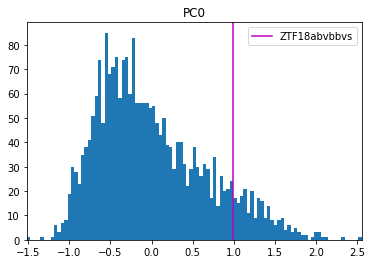

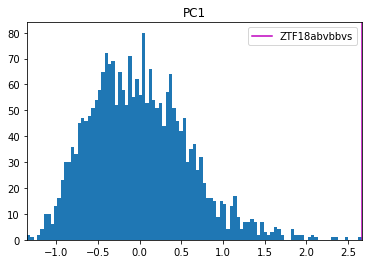

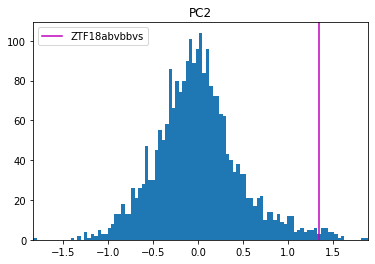

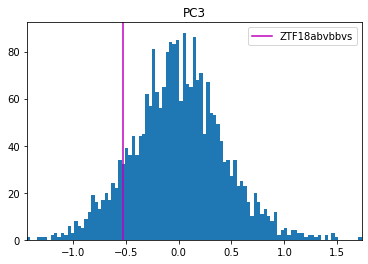

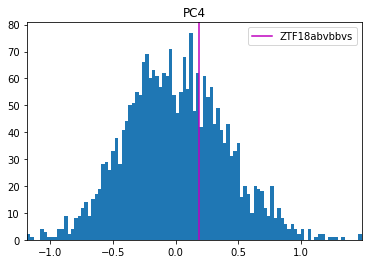

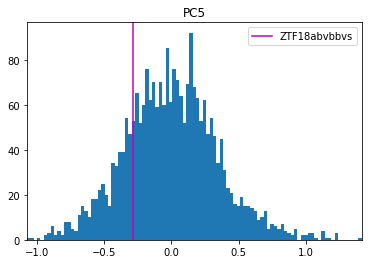

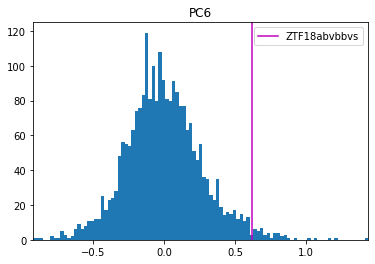

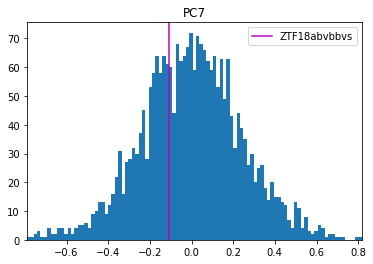

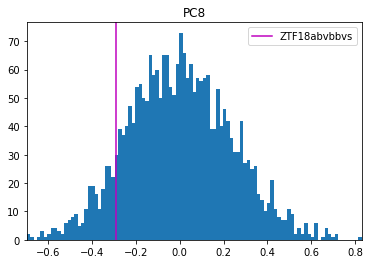

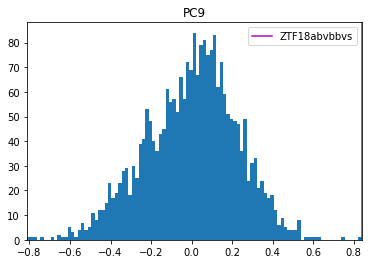

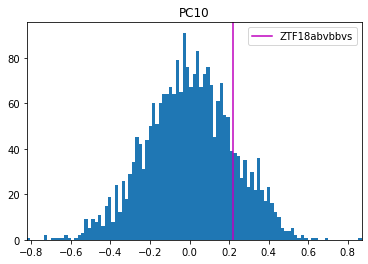

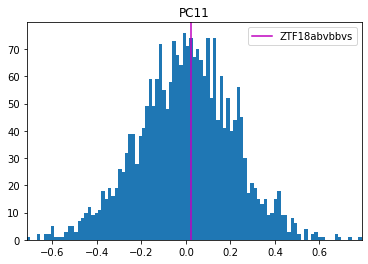

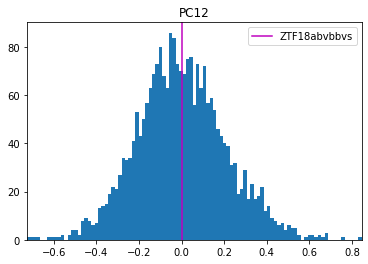

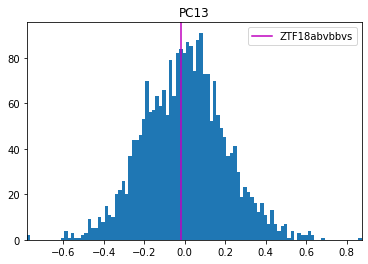

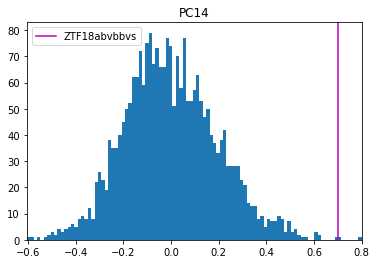

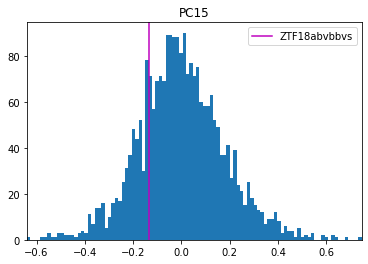

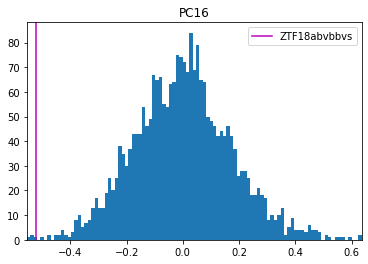

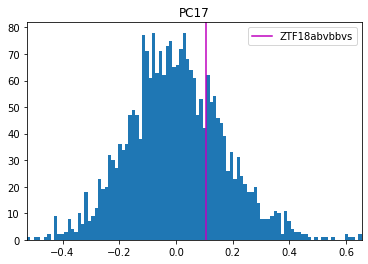

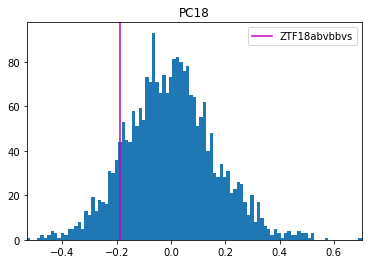

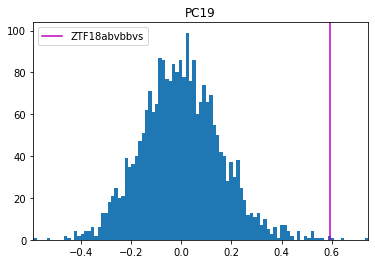

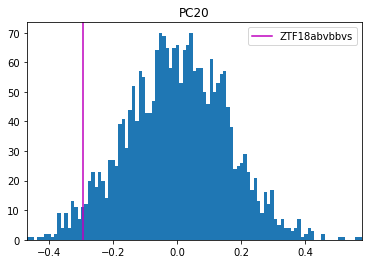

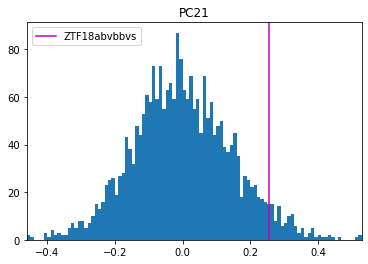

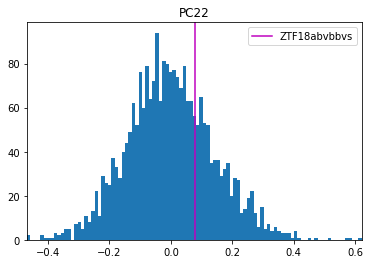

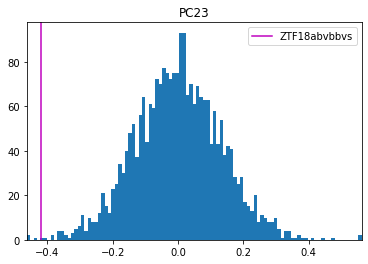

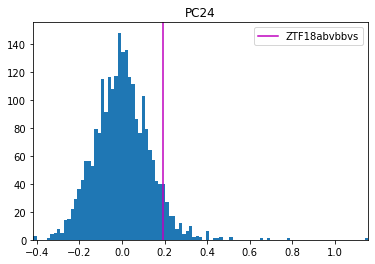

In [25]:
feat_scatter_l = []
for feat in dataset_bank.columns:
    fig, ax = plt.subplots()
    min_feat, max_feat = np.min(dataset_bank[feat]), np.max(dataset_bank[feat])
    
    ax.hist(dataset_bank[feat], bins=np.linspace(min_feat, max_feat, 100))
    
    ref = dataset_bank[dataset_bank.index == ref_obj]
    
    ax.axvline(ref[feat].values[0], color='m', label=ref_obj)
    ax.set_title(feat)
    ax.set_xlim(min_feat, max_feat)
    
    plt.legend()
    plt.show()
    
    feat_scatter = np.std(dataset_bank[feat])
    feat_scatter_l.append(feat_scatter)   

In [26]:
dataset_ref = dataset_bank[dataset_bank.index == ref_obj] #  ref_obj

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[0.9894828956858626 2.667249858317601 1.3480283311957018
 -0.5244285257318974 0.1853253264103792 -0.2858684176804523
 0.6156921926222645 -0.10714370763321754 -0.2928475221997548
 0.8390258361329719 0.22124682626228293 0.02258695873919683
 0.0007278626695263992 -0.020384508732857645 0.702178103584131
 -0.13267024959256166 -0.522775521995816 0.107081924722157
 -0.18599239942879103 0.5924962305718939 -0.2940938122141007
 0.2541293451927062 0.0770542119625486 -0.4202987853221115
 0.19312168507668692]
ZTF ID name (ref) ZTF18abvbbvs
https://alerce.online/object/ZTF18abvbbvs
%%%%%%
ANN		ZTF_id							DIST			ps1images
0	https://alerce.online/object/ZTF18abvbbvs			0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=322.6080553+-2.99355874&filter=color

1	https://alerce.online/object/ZTF20abeywdn			2.1171	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=169.0649346+36.33073303&filter=color

2	https://alerce.online/object/ZTF20acxzqyp			2.1455	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=1

In [27]:
ann_dist_all_df.loc[ref_obj]

ann=0                 1779.000000
ann=1                 1814.000000
ann=2                  593.000000
ann=3                  523.000000
ann=4                 2220.000000
ann=5                 1741.000000
ann=6                  709.000000
ann=7                  720.000000
ann=8                 2021.000000
ann=9                  366.000000
dist=0                   0.000000
dist=1                   2.117149
dist=2                   2.145480
dist=3                   2.214961
dist=4                   2.380236
dist=5                   2.391424
dist=6                   2.407336
dist=7                   2.417867
dist=8                   2.431712
dist=9                   2.434636
Mean_9ANNs               2.326756
WeightedMean_9ANNs       2.201770
Name: ZTF18abvbbvs, dtype: float64

In [28]:
# 100 largest distances
ann_dist_all_df[dist_col].nlargest(100)

key_0
ZTF18abvbbvs    2.201770
ZTF18aabjliz    1.757567
ZTF21aaaodzf    1.746348
ZTF18abvmlow    1.712568
ZTF18aamnlze    1.695196
                  ...   
ZTF18aalujjg    1.210305
ZTF19aabklex    1.209801
ZTF18abtcrmi    1.209350
ZTF18acrhiia    1.209001
ZTF18abtsuwv    1.207995
Name: WeightedMean_9ANNs, Length: 100, dtype: float64

In [29]:
# 100 largest distances objs 
for ztfid in list(ann_dist_all_df[dist_col].nlargest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF18abvbbvs

https://alerce.online/object/ZTF18aabjliz

https://alerce.online/object/ZTF21aaaodzf

https://alerce.online/object/ZTF18abvmlow

https://alerce.online/object/ZTF18aamnlze

https://alerce.online/object/ZTF18acrxszj

https://alerce.online/object/ZTF18adbmbpa

https://alerce.online/object/ZTF18achgqaz

https://alerce.online/object/ZTF19abpassc

https://alerce.online/object/ZTF18aamzgzi

https://alerce.online/object/ZTF19acxfjcy

https://alerce.online/object/ZTF20abeywdn

https://alerce.online/object/ZTF21acapylm

https://alerce.online/object/ZTF20acbeokd

https://alerce.online/object/ZTF19aalwbnj

https://alerce.online/object/ZTF18abwxrhi

https://alerce.online/object/ZTF20ablygyy

https://alerce.online/object/ZTF18aaimlad

https://alerce.online/object/ZTF18aajcvol

https://alerce.online/object/ZTF20aaocfje

https://alerce.online/object/ZTF18abtpmlk

https://alerce.online/object/ZTF18aabjkom

https://alerce.online/object/ZTF18aanlksp

https://ale

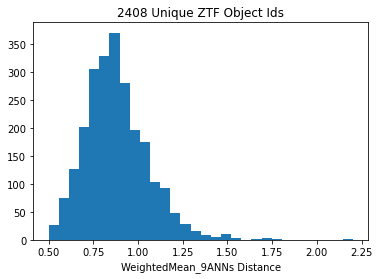

In [30]:
# 10 largest mean 9 ANN distances distances (most different)
plt.hist(ann_dist_all_df[dist_col], 
         bins=np.linspace(np.min(ann_dist_all_df[dist_col]), 
                          np.max(ann_dist_all_df[dist_col]), 31), density=False);
plt.xlabel(dist_col+' Distance');
#plt.yscale('log')
plt.title(f'{len(ann_dist_all_df)} Unique ZTF Object Ids');

In [31]:
print("summary stats")
print("Scatter mean:", np.mean(ann_dist_all_df[dist_col]))
print("Scatter median:", np.median(ann_dist_all_df[dist_col]))
print("Scatter std:", np.std(ann_dist_all_df[dist_col]))
print("Scatter max:", np.max(ann_dist_all_df[dist_col]))
print("Scatter min:", np.min(ann_dist_all_df[dist_col]))
print("\n")

#Returns index of distance
print("Most anomalous:", ann_dist_all_df[[dist_col]].idxmax().values[0])

summary stats
Scatter mean: 0.8805845188100986
Scatter median: 0.8617727373811332
Scatter std: 0.1770187126165297
Scatter max: 2.2017698369242926
Scatter min: 0.4998323507606983


Most anomalous: ZTF18abvbbvs


# Smallest

### AGN/QSOs have smallest dist

In [32]:
ann_dist_all_df[dist_col].nsmallest(10)

key_0
ZTF20achtpbn    0.499832
ZTF21aapqzxr    0.500455
ZTF21aaxksct    0.505596
ZTF20acwozwz    0.512651
ZTF20acwnrty    0.514541
ZTF18ablmduj    0.514813
ZTF21abeokcr    0.519092
ZTF19aayuxpq    0.520554
ZTF20actvmqi    0.523298
ZTF19aabyuzq    0.529998
Name: WeightedMean_9ANNs, dtype: float64

In [33]:
# 10 smallest  distances (most similar)
for ztfid in list(ann_dist_all_df[dist_col].nsmallest(100).index):
    alerce_link = f'https://alerce.online/object/{ztfid}\n'
    print(alerce_link)

https://alerce.online/object/ZTF20achtpbn

https://alerce.online/object/ZTF21aapqzxr

https://alerce.online/object/ZTF21aaxksct

https://alerce.online/object/ZTF20acwozwz

https://alerce.online/object/ZTF20acwnrty

https://alerce.online/object/ZTF18ablmduj

https://alerce.online/object/ZTF21abeokcr

https://alerce.online/object/ZTF19aayuxpq

https://alerce.online/object/ZTF20actvmqi

https://alerce.online/object/ZTF19aabyuzq

https://alerce.online/object/ZTF20acimzhq

https://alerce.online/object/ZTF20ackkejs

https://alerce.online/object/ZTF20acpzdzq

https://alerce.online/object/ZTF21aagtrkn

https://alerce.online/object/ZTF21aalnyny

https://alerce.online/object/ZTF20acuosjp

https://alerce.online/object/ZTF20acoxdas

https://alerce.online/object/ZTF20aadxyal

https://alerce.online/object/ZTF20aclnsts

https://alerce.online/object/ZTF18aawjhmu

https://alerce.online/object/ZTF20acqrahz

https://alerce.online/object/ZTF20acowuix

https://alerce.online/object/ZTF21aazebgh

https://ale

In [34]:
dataset_ref = dataset_bank[dataset_bank.index == list(ann_dist_all_df[dist_col].nsmallest(10).index)[0]]

# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = scaler.transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on
# #scaled_feat_arr_ref = scaler.fit_transform(feat_arr_ref) #scaler.transform(feat_arr) # What your model learns on

# # Scalar then PCA
# scaled_feat_arr_ref = np.array(dataset_ref)

# PCA only
feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
scaled_feat_arr_ref = feat_arr_ref

# #PCA then scaler
# feat_arr_ref = np.vstack(np.array(dataset_ref, dtype='object'))
# scaled_feat_arr_ref = feat_arr_ref


snid = dataset_ref.index.values[0]
lcdata = {'name': snid, 'vector': scaled_feat_arr_ref[0]}
#lcdata = {'name': ztf_id, 'vector': feat_arr_scaled[-5:-4][0]}
print(lcdata['vector'])

#result_id, result_dist = index.index.get_nns_by_item(, n=10, include_distances=True)
result_id, result_dist = index.index.get_nns_by_vector(lcdata['vector'], n=10, include_distances=True)
#result_name = index.query(lcdata['vector'])

# print(f"ZTF ID name (ref) {snid}") 
# link_ref = display_markdown(f'https://alerce.online/object/{snid}', raw=True)
# print(link_ref)
# print("%%%%%%")
# print("ANN\t\tIDX\t\t\t\tZTF_id\t\t\t\tDIST")#\tFEAT")
# for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
#     print(f"{n}\t\t{i}\t\t\t\t{display_markdown(f'https://alerce.online/object/{idx_arr[i]}', raw=True)}\t\t\t{round(d, 4)}")#\t{f}")

print(f"ZTF ID name (ref) {snid}") 
link_ref = f'https://alerce.online/object/{snid}'
print(link_ref)
print("%%%%%%")
print("ANN\t\tZTF_id\t\t\t\t\t\t\tDIST\t\t\tps1images")#\tFEAT")
for n, (i, d) in enumerate(zip(result_id, result_dist)):#, feat_arr):
    ra_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].raMean
    dec_i = dataset_bank_orig_host_ra_dec.loc[idx_arr[i]].decMean
    print(f"{n}\t{f'https://alerce.online/object/{idx_arr[i]}'}\t\t\t{round(d, 4)}\t{f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={ra_i}+{dec_i}&filter=color'}\n")#\t{f}")

[-0.571754532816037 0.5126096692155365 0.06308238325539232
 -0.10342059931347873 -0.368674725416767 -0.14452928609664473
 0.1359957423624723 -0.14316791570444104 0.04886391127650685
 0.04107189921383516 0.09937820213719518 0.15600496694472632
 -0.2706663077945005 -0.008439931723027917 -0.06170271246938886
 -0.2022935047344031 -0.007293893502640277 0.042316941771659476
 -0.1335849833742637 -0.06011150415520738 -0.04315197889403181
 -0.0047575985112523365 0.0371186394390599 0.09597905100398411
 0.01559715128278135]
ZTF ID name (ref) ZTF20achtpbn
https://alerce.online/object/ZTF20achtpbn
%%%%%%
ANN		ZTF_id							DIST			ps1images
0	https://alerce.online/object/ZTF20achtpbn			0.0	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=13.46558383+-18.31006067&filter=color

1	https://alerce.online/object/ZTF21aapqzxr			0.4311	http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=175.33503098+3.55086066&filter=color

2	https://alerce.online/object/ZTF20acnsinb			0.4958	http://ps1images.stsci.edu/cgi-bi

In [35]:
# dist ANN=1 and mean of first 9 ANN are roughly same (SN, CV, Mira, etc). 
# Not as many SN (but otherwise similar as above) in weighted (fibonacci) average of first 9 ANN.
# Separation will come down to host gal info

MaxAbsScaler, Euclidean, Ia

NON PCA
Scatter mean: 0.10822062189269697
Scatter median: 0.08390001702324312
Scatter std: 0.09273033952967297
Scatter max: 0.3615067063860504
Scatter min: 0.0

PCA
Scatter mean: 0.22748059656595504
Scatter median: 0.23485067052158148
Scatter std: 0.08590310140277316
Scatter max: 0.3552833440373228
Scatter min: 0.013447031738069838

MaxAbsScaler, Euclidean, SLSN

Scatter mean: 0.1882023265906344
Scatter median: 0.14632144856515017
Scatter std: 0.1839875260098897
Scatter max: 1.046586348913336
Scatter min: 0.006225538066605167

MaxAbsScaler, Euclidean, junk

Scatter mean: 0.18480675721201786
Scatter median: 0.14364864210180578
Scatter std: 0.208412667064402
Scatter max: 1.2017613918543555
Scatter min: 0.002740342445819787